In [8]:
using ComputationalHeatTransfer

In [9]:
# using Plots
using LaTeXStrings

In [10]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using Plots
pyplot()

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


Plots.PyPlotBackend()

In [11]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# the plate code initialization

### Physical parameters

In [12]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [13]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [14]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000.0)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

(0.00048567444811398473, 0.00023587966955082365)

### Set up the boundary of the domain

In [15]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 594 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [16]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = -30.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

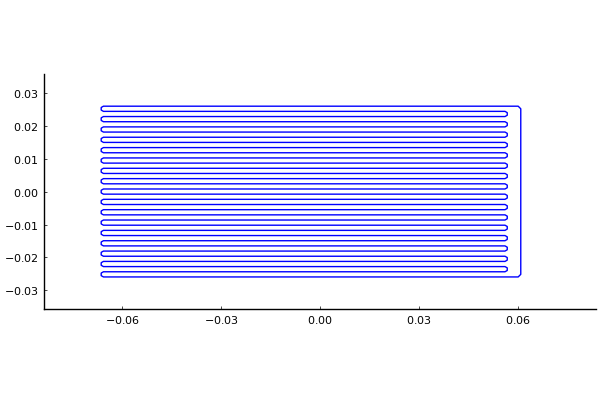

In [17]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [18]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [39]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 350 x 150 and 594 static immersed points
   1 body


#### Initialize state, and create the integrator

In [40]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 350, ny = 150) cell grid of type Float64 data
  Number of Primal nodes: (nx = 349, ny = 149), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [41]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 350 x 150 and 594 static immersed points
   1 body


In [42]:
@time step!(integrator,0.001)
maximum(integrator.u[:])

  1.179824 seconds (49.05 k allocations: 204.926 MiB, 2.13% gc time)


0.0037459943675947245

In [43]:
integrator.t

0.0011793983477541182

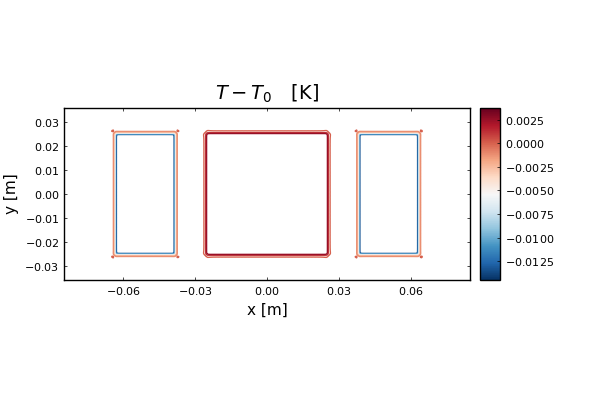

In [44]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
# plot!(ohp,fillalpha=0,line_z=qtmp)

In [45]:
maximum(integrator.u[:])

0.0037459943675947245

### Plot the temperature along the OHP channel

In [46]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

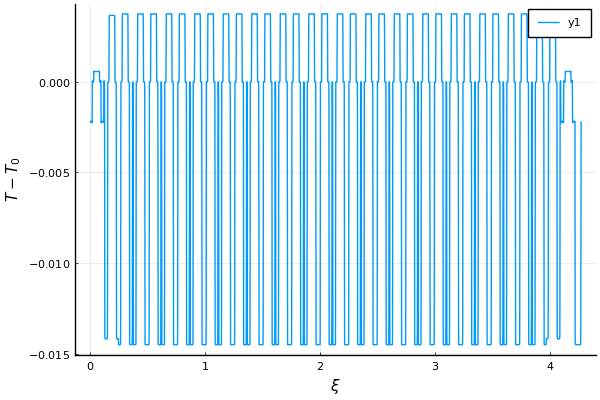

In [49]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [572]:
T0 = 273.15
nondi_Q_to_Q = 8.52e01
t_to_nondi_t = 3.42e-01
function di_T_to_nondi_T(di_T;T0=273.15) 
    
    (di_T+T0)/T0
    
end

di_T_to_nondi_T (generic function with 1 method)

In [573]:
    ω = sqrt(1.68e003);
    ℘L = 6.2e004;
    k = 115e-003

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
    Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
#     Hₗ   =  2.57e004; # liquid wall heat transfer coeffcient
    Hδ  = 7.34e002;


In [574]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [575]:
    nucleatenum = 16
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [576]:
tube = Tube(d,L,L2D,angle,closedornot);

In [577]:
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [578]:
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [579]:
numofX=16
Xps = sort(rand(2*numofX).*L);
Xp1s = Xps[1:2:end];
Xp2s = Xps[2:2:end];

dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
X0 = map(tuple,Xp1s,Xp2s);


In [580]:
N=numpts(ohp)
# X0 = [(L/4, L*3/4)]
# dXdt0 = [(0.0,0.0)]
ρ = 214.6
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [581]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 7.34e2
P = 0*Xp1s .+ 1.0;
δ = 0*Xp1s .+ 2.86e-02;
vapors=Vapor(γ,Hδ,P,δ);

In [587]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [588]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall);

In [589]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [590]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [591]:
# cb_boiling =  ContinuousCallback(boiling_condition,boiling_affect!)
cb_boiling =  PeriodicCallback(boiling_affect!,0.005*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

### solve OHP (with nondimentional wall tempeature = 1.0)

In [592]:
tstep=1e-4
# tstep=5e-5*t_to_nondi_t

p = sys0
tspan = (0.0, 0.001);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(deepcopy(prob), RK4(), dt=tstep, callback=cbst);

@time solve!(integrator_tube);


  1.639390 seconds (109.60 k allocations: 177.809 MiB, 32.42% gc time)


In [593]:
sol = integrator_tube.sol
sysfinal = getcurrentsys.(sol.u,[sys0]);

# combine inner tube and plate together

In [594]:
tspan = (0.0, 0.001);
dt_record = tspan[2] /10;
tstep=1e-4;

In [595]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 350, ny = 150) cell grid of type Float64 data
  Number of Primal nodes: (nx = 349, ny = 149), Float64[])

In [596]:
integrator_tube = init(deepcopy(prob), RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 3618-element Array{Float64,1}:
  0.333086816678676
  0.7837189657893384
  1.0134172735788627
  2.194687397131526
  3.6222015107537766
  4.153329683970906
  5.0128531836760235
  6.607923914800978
  6.6267275390044205
  7.793211358057932
 10.330116603226255
 10.653507128781332
 12.11433247607442
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [600]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0)
@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t,integrator_plate.t*t_to_nondi_t+tstep*t_to_nondi_t), currentsys)
    integrator_tube = deepcopy(init(prob, RK4(), dt=tstep*t_to_nondi_t, callback=cbst));
    step!(integrator_tube);

#   step!(integrator_tube, tstep*t_to_nondi_t, true)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(integrator_plate.t,dt_record) > 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

LoadError: [91mMethodError: no method matching step!(::OrdinaryDiffEq.ODEIntegrator{LiskaIFHERK{ConstrainedSystems.Direct},true,ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Float64,HeatConduction{350,150,594,ComputationalHeatTransfer.StaticPoints,InternalProblem,CartesianGrids.Yang3,ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}}},Float64,Float64,Float64,Float64,Array{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},1},ODESolution{Float64,2,Array{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},1},Nothing,Nothing,Array{Float64,1},Array{Array{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},1},1},ODEProblem{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Tuple{Float64,Float64},true,HeatConduction{350,150,594,ComputationalHeatTransfer.StaticPoints,InternalProblem,CartesianGrids.Yang3,ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}}},ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},SciMLBase.StandardODEProblem},LiskaIFHERK{ConstrainedSystems.Direct},OrdinaryDiffEq.InterpolationData{ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},Array{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},1},Array{Float64,1},Array{Array{ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},1},1},ConstrainedSystems.LiskaIFHERKCache{true,true,ConstrainedSystems.Direct,ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},CartesianGrids.IntFact{349,149,CartesianGrids.NegExp,false},CartesianGrids.IntFact{349,149,CartesianGrids.ZeroExp,false},Array{Any,1},HeatConduction{350,150,594,ComputationalHeatTransfer.StaticPoints,InternalProblem,CartesianGrids.Yang3,ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}}},ConstrainedSystems.LiskaIFHERKConstantCache{true,true,ConstrainedSystems.Direct,Float64,Float64}}},DiffEqBase.DEStats},ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},ConstrainedSystems.LiskaIFHERKCache{true,true,ConstrainedSystems.Direct,ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},CartesianGrids.IntFact{349,149,CartesianGrids.NegExp,false},CartesianGrids.IntFact{349,149,CartesianGrids.ZeroExp,false},Array{Any,1},HeatConduction{350,150,594,ComputationalHeatTransfer.StaticPoints,InternalProblem,CartesianGrids.Yang3,ConstrainedODEFunction{true,true,SplitFunction{true,ODEFunction{true,DiffEqLinearOperator{Float64,CartesianGrids.Laplacian{349,149,Float64,false,false}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#71#72"{typeof(heatconduction_rhs!)},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#91#92",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},SplitFunction{true,ODEFunction{true,ConstrainedSystems.var"#85#86",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},ODEFunction{true,ConstrainedSystems.var"#97#98",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},UniformScaling{Bool},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(ConstrainedSystems.DEFAULT_PARAM_UPDATE_FUNC)},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}}},ConstrainedSystems.LiskaIFHERKConstantCache{true,true,ConstrainedSystems.Direct,Float64,Float64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,PIController{Int64},typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(opnorm),Nothing,CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},Nothing,Nothing,Int64,Tuple{},Tuple{},Tuple{}},ArrayPartition{Float64,Tuple{Nodes{Primal,350,150,Float64,Array{Float64,2}},Array{Float64,1}}},Float64,Nothing,OrdinaryDiffEq.DefaultInit}, ::Float64, ::Bool; save_everystep=false)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  step!(::SciMLBase.DEIntegrator, ::Any, ::Any) at C:\Users\liyux\.julia\packages\SciMLBase\DKeLA\src\integrator_interface.jl:576[91m got unsupported keyword argument "save_everystep"[39m[39m
[91m[0m  step!(::SciMLBase.DEIntegrator, ::Any) at C:\Users\liyux\.julia\packages\SciMLBase\DKeLA\src\integrator_interface.jl:576[91m got unsupported keyword argument "save_everystep"[39m[39m
[91m[0m  step!(::OrdinaryDiffEq.ODEIntegrator) at C:\Users\liyux\.julia\packages\OrdinaryDiffEq\T2rXL\src\iterator_interface.jl:1[91m got unsupported keyword argument "save_everystep"[39m[39m
[91m[0m  ...[39m

In [554]:
integrator_tube.sol

retcode: Default
Interpolation: 3rd order Hermite
t: 2-element Array{Float64,1}:
 0.0005931159567081519
 0.0006273159567081519
u: 2-element Array{Array{Float64,1},1}:
 [3.7591100960176336, 4.029423587137307, 4.438715265697624, 5.18381065698247, 5.583902582912294, 6.623572012595156, 7.6055888341511055, 7.666382839347657, 8.197003021737249, 8.323701586689124  …  0.9999997980886498, 0.999999798090418, 0.999999798090384, 0.9999997980910043, 0.9999997980897154, 0.999999798097419, 0.9999997982012604, 0.9999997993942789, 0.9999998106797633, 0.9999998431290547]
 [3.759106175644829, 4.029419666764503, 4.438722654451766, 5.183818045736611, 5.583906744614538, 6.6235761742974, 7.605588158575679, 7.66638216377223, 8.197005114549594, 8.323703679501468  …  0.9999997750130052, 0.9999997750144924, 0.9999997750142455, 0.9999997750150312, 0.9999997750145041, 0.9999997750278329, 0.9999997751832592, 0.9999997767503561, 0.9999997900777002, 0.9999998271111483]

In [541]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [542]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

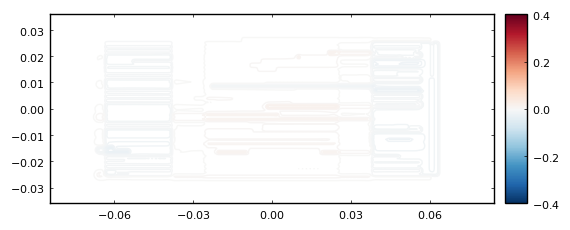

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
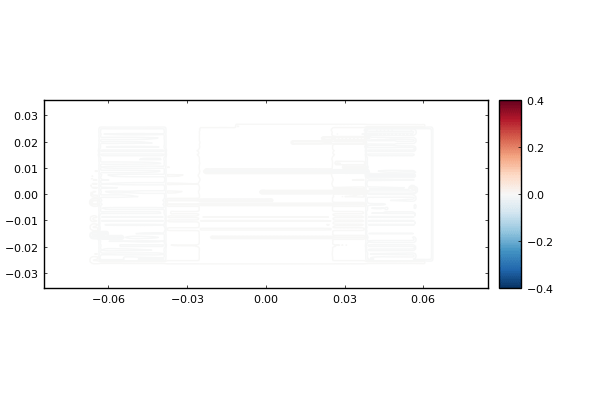

In [543]:
@gif for i = 1:5:length(plate_hist)
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,clim=(-0.4,0.4))
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

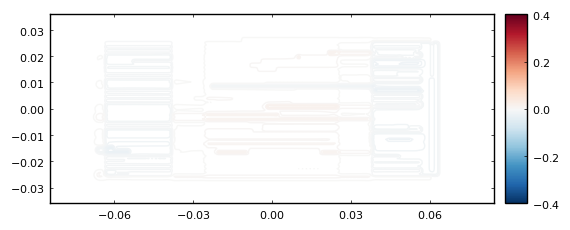

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
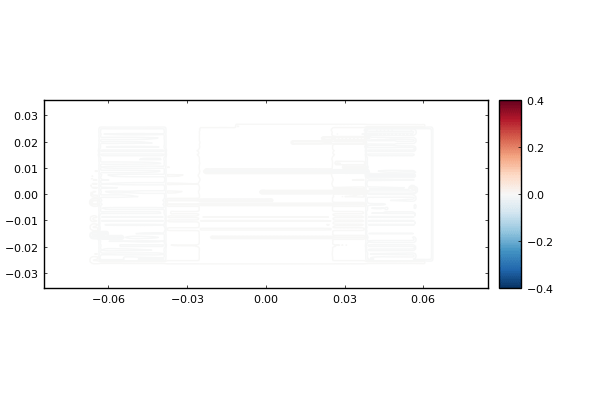

In [538]:
@gif for i = 1:5:length(plate_hist)
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,clim=(-0.4,0.4))
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

In [539]:
sysfinal[1].liquid.θarrays[2]

124-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

# plot the OHP

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5858.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

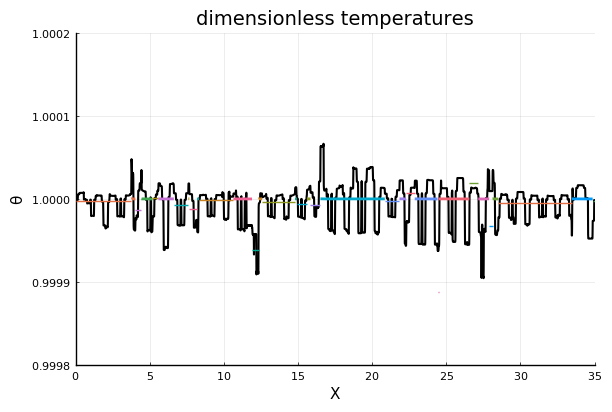

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
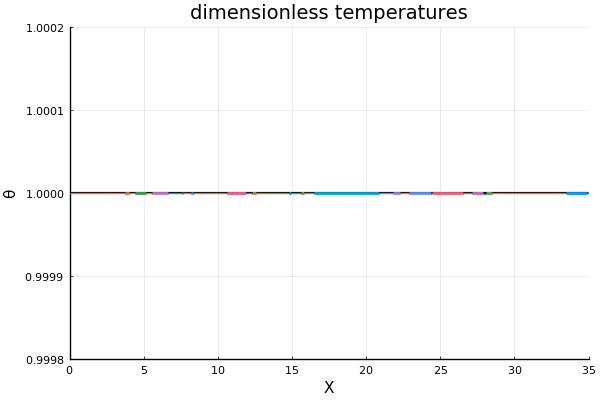

In [544]:
# closed loop plot
@gif for i=1:1:length(sysfinal)
# @gif for i=1:1:80
        
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    Xp = sysfinal[i].liquid.Xp
    
#     sysfinal[i].wall.θarray = di_T_to_nondi_T(temperature_linesource(plate_hist[i]))
    
    p = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray], linewidth=1.5, ylim=(0.9998,1.0002), color = [:black],legend=:none, labels = "θwall", xlabel="X", ylabel="θ", title=("dimensionless temperatures"),xlim=(0,sysfinal[i].tube.L))
    
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            plot!(p, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]], linewidth=2, labels = string("θliquid ",j))
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            plot!(p, [sysfinal[i].liquid.Xarrays[j][1:index-1]],[sysfinal[i].liquid.θarrays[j][1:index-1]], linewidth=2, labels = string("θliquid ",j))
            plot!(p, [sysfinal[i].liquid.Xarrays[j][index:end]],[sysfinal[i].liquid.θarrays[j][index:end]], linewidth=2, labels = string("θliquid ",j))

        end
        
        j += 1
    end

        j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            else
            
            plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))

        end
        
        j += 1
    end
    
#     j = 1
#     plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
#     plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
#     j = 2
#     while j  <= length(θvapor) 
    
#         plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
#         j += 1
#     end

#     vline!( p, [collect(0:2:4)], color=[:blue,:red], width=196, alpha=[0.3,0.3,0.3],labels = "")
    
    end 

In [52]:
# @gif for i = 1:5:length(sysfinal)
i=200
    nondi_qtmp = sys_to_heatflux(sysfinal[i])
        qtmp = nondi_Q_to_Q*nondi_qtmp
#         set_linesource_strength!(sys,qtmp)
    plot(sysfinal[i].wall.Xarray,qtmp,ylim=(0.0,8e5))
# end

LoadError: [91mUndefVarError: sysfinal not defined[39m

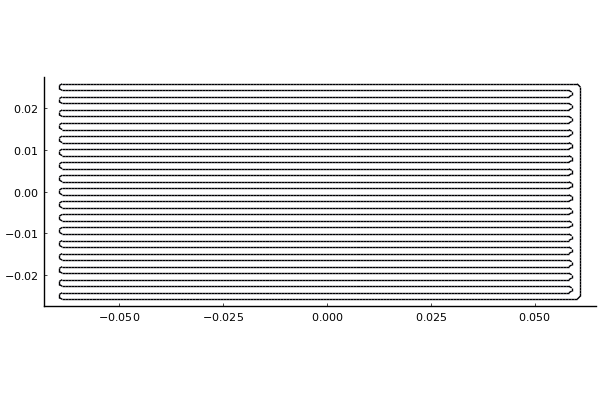

In [54]:
plot(ohp,fillalpha=0,line_z=qtmp)